In [42]:
%pip install llama-index llama-index-embeddings-ollama ollama pypdf #pypdf to extract text from pdfs, and Ollama is the LLM server, 
%pip install llama-index llama-index-llms-ollama llama-index-embeddings-ollama
import os #manage file paths and create directories
import os.path
import matplotlib.pyplot as plt #visualize text length per page in PDFs
from PyPDF2 import PdfReader #extract text from PDFs
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, Settings
from llama_index.llms.ollama import Ollama
from llama_index.embeddings.ollama import OllamaEmbedding
from llama_index.core.node_parser import SimpleNodeParser
from llama_index.core.storage.docstore import SimpleDocumentStore
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core import ServiceContext
from pypdf import PdfReader

llm = Ollama(model="deepseek-r1:latest") 
Settings.llm = llm

embedding_model = OllamaEmbedding(model_name="nomic-embed-text:latest") 
Settings.embed_model = embedding_model 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [43]:
import os.path
from llama_index.core import (
    VectorStoreIndex,
    SimpleDirectoryReader,
)

documents = SimpleDirectoryReader("data").load_data()


DEBUG:llama_index.core.readers.file.base:> [SimpleDirectoryReader] Total files added: 3
> [SimpleDirectoryReader] Total files added: 3
> [SimpleDirectoryReader] Total files added: 3
> [SimpleDirectoryReader] Total files added: 3
DEBUG:fsspec.local:open file: /Users/raed/conda/llamaindex_playground/data/Critical-Systems-Cybersecurity-Controls.pdf
open file: /Users/raed/conda/llamaindex_playground/data/Critical-Systems-Cybersecurity-Controls.pdf
open file: /Users/raed/conda/llamaindex_playground/data/Critical-Systems-Cybersecurity-Controls.pdf
open file: /Users/raed/conda/llamaindex_playground/data/Critical-Systems-Cybersecurity-Controls.pdf
DEBUG:fsspec.local:open file: /Users/raed/conda/llamaindex_playground/data/Critical-Systems-Cybersecurity-Controls.txt
open file: /Users/raed/conda/llamaindex_playground/data/Critical-Systems-Cybersecurity-Controls.txt
open file: /Users/raed/conda/llamaindex_playground/data/Critical-Systems-Cybersecurity-Controls.txt
open file: /Users/raed/conda/llam

In [44]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

In [45]:
# convert data/Critical-Systems.pdf to text and store it in data/Critical-Systems.txt
# this is a one-time operation
import PyPDF2

#reader = PyPDF2.PdfReader('data/Critical-Systems-Cybersecurity-Controls.pdf')
#text = "\n".join(page.extract_text() for page in reader.pages)

documents = SimpleDirectoryReader(input_files=['data/Critical-Systems-Cybersecurity-Controls.pdf']).load_data()

DEBUG:fsspec.local:open file: /Users/raed/conda/llamaindex_playground/data/Critical-Systems-Cybersecurity-Controls.pdf
open file: /Users/raed/conda/llamaindex_playground/data/Critical-Systems-Cybersecurity-Controls.pdf
open file: /Users/raed/conda/llamaindex_playground/data/Critical-Systems-Cybersecurity-Controls.pdf
open file: /Users/raed/conda/llamaindex_playground/data/Critical-Systems-Cybersecurity-Controls.pdf
open file: /Users/raed/conda/llamaindex_playground/data/Critical-Systems-Cybersecurity-Controls.pdf


## What to skip
1. First page
2. pages with no text
3. Pages withg short paragraphs. Below on a simple way to calcualte the proper number of words to skip
4. Pages that start with 'Disclaimer' 


(array([3., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
        0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 1., 1., 1., 0., 2., 0.,
        0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([  1.  ,   4.56,   8.12,  11.68,  15.24,  18.8 ,  22.36,  25.92,
         29.48,  33.04,  36.6 ,  40.16,  43.72,  47.28,  50.84,  54.4 ,
         57.96,  61.52,  65.08,  68.64,  72.2 ,  75.76,  79.32,  82.88,
         86.44,  90.  ,  93.56,  97.12, 100.68, 104.24, 107.8 , 111.36,
        114.92, 118.48, 122.04, 125.6 , 129.16, 132.72, 136.28, 139.84,
        143.4 , 146.96, 150.52, 154.08, 157.64, 161.2 , 164.76, 168.32,
        171.88, 175.44, 179.  , 182.56, 186.12, 189.68, 193.24, 196.8 ,
        200.36, 203.92, 207.48, 211.04, 214.6 

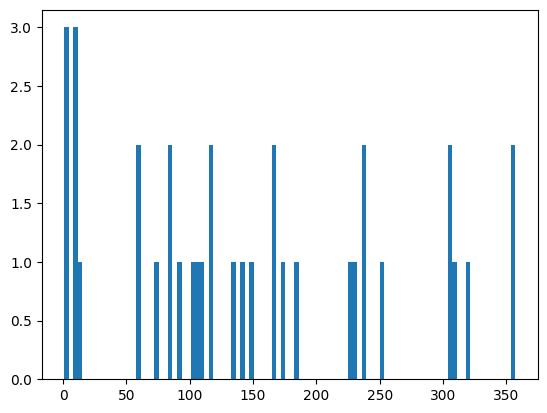

In [46]:
import matplotlib.pyplot as plt

words_per_page = [len(page.text.split(' ')) for page in documents]
plt.hist(words_per_page, bins=100)

In [47]:
# Skip first page
documents = documents[1:]

In [48]:
# Skip empty pages
_ = []
for document in documents:
    if len(document.text) > 0:
        _.append(document)
documents = _

In [49]:
# Skip all pages with less than 50 words
_ = []
for document in documents:
    if len(document.text.split(' ')) > 50:
        _.append(document)

documents = _

In [50]:
# Skip documents that start with 'Disclaimer'
_ = []
for document in documents:
    if not document.text.startswith('Disclaimer'):
        _.append(document)
documents = _

In [51]:
documents

[Document(id_='76b0565b-259a-4fb2-85ef-76b4db72650f', embedding=None, metadata={'page_label': '6', 'file_name': 'Critical-Systems-Cybersecurity-Controls.pdf', 'file_path': 'data/Critical-Systems-Cybersecurity-Controls.pdf', 'file_type': 'application/pdf', 'file_size': 686781, 'creation_date': '2025-02-06', 'last_modified_date': '2025-02-06'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='6\nDocument Classification: Open\nCritical Systems Cybersecurity ControlsSharing Indicator:  White\nTraffic Light Protocol (TLP):\nThis marking protocol is widely used around the world. It has four colors (traffic lights):\n   Red – Personal, Confidentia

In [52]:
llm = Ollama(model="deepseek-r1:8b") 
Settings.llm = llm

#embedding_model = OllamaEmbedding(model_name="all-minilm:latest") 
#Settings.embed_model = embedding_model 
index = VectorStoreIndex.from_documents(documents)

DEBUG:llama_index.core.node_parser.node_utils:> Adding chunk: 6
Document Classification: Open
Critical System...
> Adding chunk: 6
Document Classification: Open
Critical System...
> Adding chunk: 6
Document Classification: Open
Critical System...
> Adding chunk: 6
Document Classification: Open
Critical System...
> Adding chunk: 6
Document Classification: Open
Critical System...
DEBUG:llama_index.core.node_parser.node_utils:> Adding chunk: 8
Document Classification: Open
Critical System...
> Adding chunk: 8
Document Classification: Open
Critical System...
> Adding chunk: 8
Document Classification: Open
Critical System...
> Adding chunk: 8
Document Classification: Open
Critical System...
> Adding chunk: 8
Document Classification: Open
Critical System...
DEBUG:llama_index.core.node_parser.node_utils:> Adding chunk: 10
Document Classification: Open
Critical Syste...
> Adding chunk: 10
Document Classification: Open
Critical Syste...
> Adding chunk: 10
Document Classification: Open
Critical 

In [53]:
query_engine = index.as_query_engine()

In [54]:
print(query_engine.query('hi'))

DEBUG:httpcore.http11:send_request_headers.started request=<Request [b'POST']>
send_request_headers.started request=<Request [b'POST']>
send_request_headers.started request=<Request [b'POST']>
send_request_headers.started request=<Request [b'POST']>
send_request_headers.started request=<Request [b'POST']>
DEBUG:httpcore.http11:send_request_headers.complete
send_request_headers.complete
send_request_headers.complete
send_request_headers.complete
send_request_headers.complete
DEBUG:httpcore.http11:send_request_body.started request=<Request [b'POST']>
send_request_body.started request=<Request [b'POST']>
send_request_body.started request=<Request [b'POST']>
send_request_body.started request=<Request [b'POST']>
send_request_body.started request=<Request [b'POST']>
DEBUG:httpcore.http11:send_request_body.complete
send_request_body.complete
send_request_body.complete
send_request_body.complete
send_request_body.complete
DEBUG:httpcore.http11:receive_response_headers.started request=<Request 

In [26]:
query_engine.get_prompts()['response_synthesizer:text_qa_template']

SelectorPromptTemplate(metadata={'prompt_type': <PromptType.QUESTION_ANSWER: 'text_qa'>}, template_vars=['context_str', 'query_str'], kwargs={}, output_parser=None, template_var_mappings={}, function_mappings={}, default_template=PromptTemplate(metadata={'prompt_type': <PromptType.QUESTION_ANSWER: 'text_qa'>}, template_vars=['context_str', 'query_str'], kwargs={}, output_parser=None, template_var_mappings=None, function_mappings=None, template='Context information is below.\n---------------------\n{context_str}\n---------------------\nGiven the context information and not prior knowledge, answer the query.\nQuery: {query_str}\nAnswer: '), conditionals=[(<function is_chat_model at 0x10e1b8860>, ChatPromptTemplate(metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>}, template_vars=['context_str', 'query_str'], kwargs={}, output_parser=None, template_var_mappings=None, function_mappings=None, message_templates=[ChatMessage(role=<MessageRole.SYSTEM: 'system'>, additional_kwargs={}, bloc